In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
initial_data = pd.read_csv('/Users/rea/Desktop/Rylee/Individual Project/HTS/M3C-year-simplified.csv')
initial_data = initial_data.dropna(axis = 1)
initial_data.head()

,Series,N,NF,Category,Starting Year,Unnamed: 5,1,2,3,4,...,11,12,13,14,15,16,17,18,19,20
0,N 1,20,6,MICRO,1975,1,940.66,1084.86,1244.98,1445.02,...,3360.27,3807.63,4387.88,4936.99,5379.75,6158.68,6876.58,7851.91,8407.84,9156.01
1,N 2,20,6,MICRO,1975,1,1991.05,2306.40,2604.00,2992.30,...,5384.40,3656.20,4034.80,4230.00,4793.20,5602.00,5065.00,5056.00,5067.20,5209.60
2,N 3,20,6,MICRO,1975,1,1461.57,1692.50,2193.82,2459.68,...,4344.60,2897.40,3256.40,3525.20,3070.20,3601.60,3407.40,3500.60,3437.80,3007.00
3,N 4,20,6,MICRO,1975,1,744.54,1105.16,1417.40,1838.04,...,3808.64,3114.42,3847.20,4632.30,4656.00,5228.52,5656.72,5077.02,5403.40,5009.52
4,N 5,20,6,MICRO,1975,1,4977.18,5248.00,5370.00,6184.89,...,5117.64,4332.90,4620.50,5488.80,5250.90,4899.20,4317.90,4007.90,4323.40,4819.40


In [3]:
#train = train.fillna(0)
initial_data = initial_data.drop(initial_data.columns[[1,2,3,4,5]], axis=1)
initial_data.set_index(['Series'], inplace = True)
train = initial_data
train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Series,,,,,,,,,,,,,,,,,,,,
N 1,940.66,1084.86,1244.98,1445.02,1683.17,2038.15,2342.52,2602.45,2927.87,3103.96,3360.27,3807.63,4387.88,4936.99,5379.75,6158.68,6876.58,7851.91,8407.84,9156.01
N 2,1991.05,2306.40,2604.00,2992.30,3722.08,5226.62,5989.46,5614.62,5527.00,5389.80,5384.40,3656.20,4034.80,4230.00,4793.20,5602.00,5065.00,5056.00,5067.20,5209.60
N 3,1461.57,1692.50,2193.82,2459.68,3246.80,4748.86,5559.46,5292.42,5029.40,4753.60,4344.60,2897.40,3256.40,3525.20,3070.20,3601.60,3407.40,3500.60,3437.80,3007.00
N 4,744.54,1105.16,1417.40,1838.04,2337.62,3094.88,4280.04,5070.20,3675.18,3667.38,3808.64,3114.42,3847.20,4632.30,4656.00,5228.52,5656.72,5077.02,5403.40,5009.52
N 5,4977.18,5248.00,5370.00,6184.89,7137.19,6743.00,7298.00,5260.29,4898.18,5392.04,5117.64,4332.90,4620.50,5488.80,5250.90,4899.20,4317.90,4007.90,4323.40,4819.40


<AxesSubplot:xlabel='Series'>

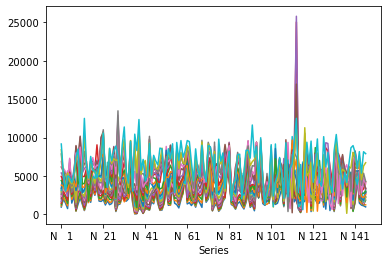

In [4]:
train.plot(legend = None)

In [5]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
from numpyro.contrib.control_flow import scan
import jax.numpy as jnp
import jax

assert numpyro.__version__.startswith("0.9.2")

![jupyter](./cwpics/pic12.png)

In [39]:
series_code = train.index.values.astype(str)
y = train.loc[series_code].values.astype(float)
y = jax.numpy.asarray(y)
#simplified
y = y[0]
y.shape[0]

20

In [71]:
def model(y, predict = False):
    
    T = y.shape[0]
    #n_series = len(series_code)
    
    level_smoothing_mu = numpyro.sample('level_smoothing_mu', dist.Normal(0,100))
    level_smoothing_sigma = numpyro.sample('level_smoothing_sigma', dist.HalfNormal(100.0))
    level_init = numpyro.sample("level_init",dist.Normal(0,100))
    
    #with numpyro.plate("plate_i", n_series):
    level_smoothing = numpyro.sample("level_smoothing", dist.Normal(level_smoothing_mu, level_smoothing_sigma))
        
    sigma = numpyro.sample("sigma", dist.HalfNormal(100.0))
    
    
    def transition_fn(carry,t):
        level_est = 0
        previous_level = y[0]
        level_est = level_smoothing * y[t] + (1-level_smoothing) * previous_level
        previous_level = level_est
        carry = None
        t += 1 
        predictions = numpyro.sample("y_prediction", dist.Normal(level_est, sigma))
        return carry, None
        
    init_carry = None
    time_indices = jnp.arange(2,y.shape[0])
    
    if predict:
        scan(transition_fn, init_carry, time_indices)
    
    else:
        with numpyro.handlers.condition(data={"y_prediction": y[2:]}):
            scan(transition_fn, init_carry, time_indices)
   

In [72]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(12)
keys = random.split(rng_key,10)

#mcmc.run(rng_key,y,series_code)
mcmc.run(keys[2],y=y)

posterior_samples = mcmc.get_samples()

sample: 100%|█| 4000/4000 [00:06<00:00, 627.01it/s, 1023 steps of size 5.26e-07.


In [73]:
mcmc.print_summary()


                             mean       std    median      5.0%     95.0%     n_eff     r_hat
             level_init     -0.89      0.00     -0.89     -0.89     -0.89      0.50      1.00
        level_smoothing      1.00      0.00      1.00      1.00      1.00       nan       nan
     level_smoothing_mu      1.83      0.00      1.83      1.83      1.83      0.50      1.00
  level_smoothing_sigma      0.54      0.00      0.54      0.54      0.54      0.50      1.00
                  sigma      0.01      0.00      0.01      0.01      0.01      0.50      1.00

Number of divergences: 0


In [74]:
predictive_model = Predictive(model, posterior_samples)
predictions = predictive_model(keys[3], y=y, predict=True)["y_prediction"]
residuals = y[2:] - predictions
quantiles = jnp.quantile(residuals, jnp.array([0.25, 0.5, 0.75]), axis=0)

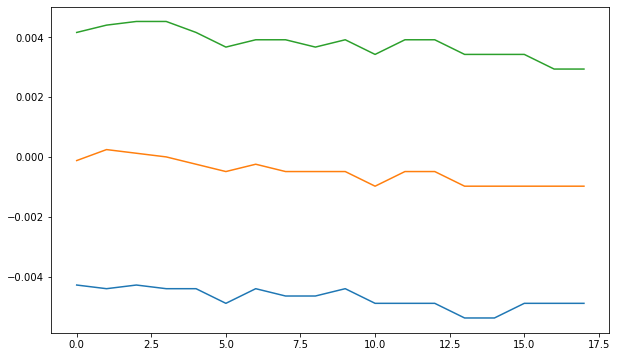

In [75]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.plot(quantiles.T)